# Plot Gridded SWE Metrics

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import altair as alt
import xarray as xr
from shapely import Polygon
import matplotlib.pyplot as plt
import contextily as ctx
import rioxarray as rxr

### Load Data:

In [2]:
swe = xr.open_dataset('../../data/reanalysis/swe_reanalysis_ucrb.nc')

In [5]:
# Mean of all stations in the UCRB
calculated_swe_mean_snv_ucrb_all = xr.open_dataset('../../data/calculated_swe/snv/calculated_swe_mean_snv_ucrb_all.nc')
calculated_swe_quantiles_mean_all = xr.open_dataset('../../data/calculated_swe/quantiles/calculated_swe_quantile_mean_all_q8.nc')

# Mean of within-station clusters, by different cluster definitions
calculated_swe_mean_snv_wus_coarse = xr.open_dataset('../../data/calculated_swe/snv/calculated_swe_mean_snv_wus_coarse2.nc')
calculated_swe_quantiles_wus_coarse_q8 = xr.open_dataset('../../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_wus_coarse_q8_2.nc')
#calculated_swe_mean_snv_wus_origres = xr.open_dataset('../../data/calculated_swe/snv/calculated_swe_mean_snv_wus_origres.nc')
#calculated_swe_quantiles_wus_origres_q8 = xr.open_dataset('../../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_wus_origres_q8.nc')
#calculated_swe_mean_snv_ucrb_origres = xr.open_dataset('../../data/calculated_swe/snv/calculated_swe_mean_snv_ucrb_origres.nc')
#calculated_swe_quantiles_ucrb_origres_q8 = xr.open_dataset('../../data/calculated_swe/quantiles/calculated_swe_quantile_mean_wic_ucrb_origres_q8.nc')

# Nearest station
calculated_swe_nearest_snv_nc = xr.open_dataset('../../data/calculated_swe/snv/calculated_swe_nearest_snv_nc.nc')
calculated_swe_nearest_station_quantile_q8 = xr.open_dataset('../../data/calculated_swe/quantiles/calculated_swe_nearest_station_quantile_q8.nc')

# Cumulative precipitation
calculated_swe_precip = xr.open_dataset('../../data/calculated_swe/prism/calculated_swe_prism_cumulative_coldseason_precip_clean.nc')

# SWE mapping from nearest station
nearest_station_swe_mapping = xr.open_dataset('../../data/calculated_swe/calculated_swe_nearest_swemapping.nc')

snowmodel = xr.open_dataset('../../data/snowmodel/sm_swed_ucrb_match_2000_2021.nc', decode_coords="all")

In [7]:
ucrb = pickle.load(open('../../data/misc/ucrb.pkl', 'rb'))

In [8]:
swe_year = swe.rename(Year="time")
swe_year['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")

### Compare to Reanalysis from the 'current' year:

In [9]:
sca = []

for year in np.arange(0,32):
    sca.append(np.sum(swe.SWE_Post[year] == 0).values)

sca_perc = ((swe.SWE_Post[0].count().values - sca) / swe.SWE_Post[0].count().values) *100

In [128]:
Rs = []
for year in np.arange(0,32):
    Rs.append(np.corrcoef(swe.SWE_Post[year].where(swe.SWE_Post.mean(dim='Year')>0).values.flatten(), calculated_swe_quantiles_mean_all.SWE_Post[year].where(swe.SWE_Post.mean(dim='Year')>0).values.flatten())[0,1])

In [127]:
swe.SWE_Post[year].where(swe.SWE_Post.mean(dim='Year')>0).values.sum()

nan

In [ ]:
Rs = []
Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten(), calculated_swe[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten())[0,1])

In [120]:
def calculate_metrics(calculated_swe, version = 'Mean SNV of within-cluster stations', method= 'SNV'):
    dif_swe = calculated_swe.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)
    Rs = []
    MDs = []
    RMSEs = []
    for year in np.arange(0,32):
        Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten(), calculated_swe[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten())[0,1])
        MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
        RMSEs.append(np.sqrt(np.nanmean((calculated_swe[year].values[calculated_swe[year].notnull()] - swe.SWE_Post[year].values[calculated_swe[year].notnull()].flatten()) ** 2)))
    
    data = {
        "Rs": Rs,
        "MDs": MDs,
        "RMSEs": RMSEs,
        #'StD': std
        'year': np.arange(1990,2022),
        'sca_percent': sca_perc,
        "version":version,
        "method": method
    }

    #load data into a DataFrame object:
    df = pd.DataFrame(data)
    
    return df

In [121]:
def calculate_metrics_year(calculated_swe, version = 'Mean SNV of within-cluster stations', method= 'SNV'):
    dif_swe = calculated_swe.where(swe.SWE_Post.mean(dim='Year')>0) - swe_year.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)
    Rs = []
    MDs = []
    RMSEs = []
    for year in np.arange(0,32):
        Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten(), calculated_swe[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten())[0,1])
        MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
        RMSEs.append(np.sqrt(np.nanmean((calculated_swe[year].values[calculated_swe[year].notnull()] - swe.SWE_Post[year].values[calculated_swe[year].notnull()].flatten()) ** 2)))
    
    data = {
        "Rs": Rs,
        "MDs": MDs,
        "RMSEs": RMSEs,
        #'StD': std
        'year': np.arange(1990,2022),
        'sca_percent': sca_perc,
        "version":version,
        "method": method
    }

    #load data into a DataFrame object:
    df = pd.DataFrame(data)
    
    return df

In [122]:
def calculate_metrics_sm(calculated_swe, version = 'SnowModel', method= 'Model'):
    dif_swe = calculated_swe.swed.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post[10:].where(swe.SWE_Post.mean(dim='Year')>0)
    Rs = []
    MDs = []
    RMSEs = []
    for year in np.arange(0,22):
        Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe.swed[year].notnull()].flatten(), calculated_swe.swed[year].values[swe.SWE_Post[year].notnull() & calculated_swe.swed[year].notnull()].flatten())[0,1])
        MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
        RMSEs.append(np.sqrt(np.nanmean((calculated_swe.swed[year].values[calculated_swe.swed[year].notnull()] - swe.SWE_Post[year].values[calculated_swe.swed[year].notnull()].flatten()) ** 2)))
    
    data = {
        "Rs": Rs,
        "MDs": MDs,
        "RMSEs": RMSEs,
        #'StD': std
        'year': np.arange(2000,2022),
        'sca_percent': sca_perc[10:],
        "version":version,
        "method": method
    }

    #load data into a DataFrame object:
    df = pd.DataFrame(data)
    
    return df

In [22]:
swe_year.SWE_Post[10:]

<xarray.DataArray 'SWE_Post' (time: 22, y: 1776, x: 1508)> Size: 236MB
[58920576 values with dtype=float32]
Coordinates:
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * time         (time) object 176B 2000-04-01 00:00:00 ... 2021-04-01 00:00:00
    spatial_ref  int64 8B ...
Attributes:
    Units:    meters

In [27]:
dif_swe = snowmodel.swed - swe.SWE_Post[10:]

In [28]:
dif_swe

<xarray.DataArray (Year: 22, y: 1776, x: 1508)> Size: 236MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * Year         (Year) int64 176B 2000 2001 2002 2003 ... 2018 2019 2020 2021
    spatial_ref  int64 8B 0
  * x            (x) float64 12kB -112.3 -112.3 -112.3 ... -105.6 -105.6 -105.6
  * y            (y) float64 14kB 35.56 35.57 35.57 35.58 ... 43.44 43.45 43.45

In [29]:
Rs = []
MDs = []
RMSEs = []
for year in np.arange(0,22):
    Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & snowmodel.swed[year].notnull()].flatten(), snowmodel.swed[year].values[swe.SWE_Post[year].notnull() & snowmodel.swed[year].notnull()].flatten())[0,1])
    MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
    RMSEs.append(np.sqrt(np.nanmean((snowmodel.swed[year].values[snowmodel.swed[year].notnull()] - swe.SWE_Post[year].values[snowmodel.swed[year].notnull()].flatten()) ** 2)))

In [32]:
sca_perc[10:]

array([42.27265717, 45.66911199, 41.45130578, 41.33283605, 37.26324606,
       44.61288597, 45.08540983, 37.40320294, 59.21847405, 41.74096297,
       59.75836305, 52.31038552, 43.48445537, 41.798133  , 42.41377553,
       26.74718651, 48.82475579, 46.25003952, 31.49597713, 60.24011413,
       50.75763197, 46.63016216])

In [34]:
data = {
    "Rs": Rs,
    "MDs": MDs,
    "RMSEs": RMSEs,
    #'StD': std
    'year': np.arange(2000,2022),
    'sca_percent': sca_perc[10:],
    "version": 'SnowModel',
    "method": 'SnowModel'
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

#return df

In [35]:
df

Rs       MDs     RMSEs  year  sca_percent    version     method
0   0.801205 -0.017478  0.073210  2000    42.272657  SnowModel  SnowModel
1   0.778556 -0.026388  0.090008  2001    45.669112  SnowModel  SnowModel
2   0.605444 -0.019371  0.150797  2002    41.451306  SnowModel  SnowModel
3   0.742295 -0.025065  0.176240  2003    41.332836  SnowModel  SnowModel
4   0.727575 -0.021962  0.080488  2004    37.263246  SnowModel  SnowModel
5   0.799286 -0.014651  0.105511  2005    44.612886  SnowModel  SnowModel
6   0.803341 -0.019101  0.125393  2006    45.085410  SnowModel  SnowModel
7   0.722329 -0.018677  0.151359  2007    37.403203  SnowModel  SnowModel
8   0.781735 -0.023716  0.114361  2008    59.218474  SnowModel  SnowModel
9   0.785734 -0.006319  0.075822  2009    41.740963  SnowModel  SnowModel
10  0.757869 -0.034013  0.104052  2010    59.758363  SnowModel  SnowModel
11  0.749858 -0.011480  0.108686  2011    52.310386  SnowModel  SnowModel
12  0.663524 -0.016669  0.088000  2012    43.484455  SnowModel  SnowModel
13  0.805993 -0.015193  0.100751  2013    41.798133  SnowModel  SnowModel
14  0.762408 -0.025860  0.084938  2014    42.413776  SnowModel  SnowModel
15  0.595041 -0.013969  0.187151  2015    26.747187  SnowModel  SnowModel
16  0.826557 -0.034032  0.112289  2016    48.824756  SnowModel  SnowModel
17  0.730697 -0.015395  0.115595  2017    46.250040  SnowModel  SnowModel
18  0.629316 -0.011377  0.160592  2018    31.495977  SnowModel  SnowModel
19  0.790397 -0.030330  0.097363  2019    60.240114  SnowModel  SnowModel
20  0.667929 -0.030389  0.117741  2020    50.757632  SnowModel  SnowModel
21  0.787758 -0.020977  0.132119  2021    46.630162  SnowModel  SnowModel

In [ ]:
#def calculate_metrics_sm(calculated_swe, version = 'Mean SNV of within-cluster stations', method= 'SNV'):
dif_swe = snowmodel.swed - swe_year.SWE_Post[10:]
Rs = []
MDs = []
RMSEs = []
for year in np.arange(0,22):
    Rs.append(np.corrcoef(swe.SWE_Post[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten(), calculated_swe[year].values[swe.SWE_Post[year].notnull() & calculated_swe[year].notnull()].flatten())[0,1])
    MDs.append(dif_swe[year].values[dif_swe[year].notnull()].mean())
    RMSEs.append(np.sqrt(np.nanmean((calculated_swe[year].values[calculated_swe[year].notnull()] - swe.SWE_Post[year].values[calculated_swe[year].notnull()].flatten()) ** 2)))

data = {
    "Rs": Rs,
    "MDs": MDs,
    "RMSEs": RMSEs,
    #'StD': std
    'year': np.arange(2000,2022),
    'sca_percent': sca_perc,
    "version":version,
    "method": method
}

#load data into a DataFrame object:
df = pd.DataFrame(data)

return df

In [47]:
quantiles_mean_all_df = calculate_metrics(calculated_swe_quantiles_mean_all.SWE_Post, version='Mean Quantile of all UCRB Stations', method = 'Quantile')

In [48]:
quantiles_mean_all_df['version'] = 'Quantile Mean of all UCRB Stations'

In [49]:
mean_snv_ucrb_all_df = calculate_metrics(calculated_swe_mean_snv_ucrb_all.SWE_Post, version='Mean SNV of all UCRB Stations', method = 'SNV')

In [50]:
mean_snv_ucrb_all_df['version'] = 'SNV Mean of all UCRB Stations'

In [78]:
mean_snv_wus_coarse_df = calculate_metrics(calculated_swe_mean_snv_wus_coarse.SWE_Post, version='Mean SNV of WIC WUS coarse', method = 'SNV')

In [79]:
mean_snv_wus_coarse_df['version'] = 'SNV Mean of within-cluster UCRB Stations'

In [80]:
quantiles_wus_coarse_df = calculate_metrics(calculated_swe_quantiles_wus_coarse_q8.SWE_Post, version='Mean Quantile of WIC WUS coarse', method = 'Quantile')

In [81]:
quantiles_wus_coarse_df['version'] = 'Quantile Mean of within-cluster UCRB Stations'

In [34]:
snv_wus_origres_df = calculate_metrics(calculated_swe_mean_snv_wus_origres.SWE_Post, version='Mean SNV of WIC WUS origres', method = 'SNV')

In [35]:
quantiles_wus_origres_df = calculate_metrics(calculated_swe_quantiles_wus_origres_q8.SWE_Post, version='Mean Quantile of WIC WUS origres', method = 'Quantile')

In [36]:
snv_ucrb_origres_df = calculate_metrics(calculated_swe_mean_snv_ucrb_origres.SWE_Post, version='Mean SNV of WIC UCRB origres', method = 'SNV')

In [37]:
quantiles_ucrb_origres_df = calculate_metrics(calculated_swe_quantiles_ucrb_origres_q8.SWE_Post, version='Mean Quantile of WIC UCRB origres', method = 'Quantile')

In [51]:
nearest_snv_nc_df = calculate_metrics(calculated_swe_nearest_snv_nc.SWE_Post, version='SNV of Nearest Station', method = 'SNV')

In [52]:
nearest_quantile_nc_df = calculate_metrics(calculated_swe_nearest_station_quantile_q8.SWE_Post, version='Quantile of Nearest Station', method = 'Quantile')

In [31]:
#cumulative_precip_df = calculate_metrics(calculated_swe_precip.__xarray_dataarray_variable__, version='PRISM Cumulative Precip', method = 'Precip')
cumulative_precip_df = calculate_metrics_year(calculated_swe_precip.__xarray_dataarray_variable__, version='PRISM Cumulative Precip', method = 'Precip')


In [38]:
snowmodel_df = calculate_metrics_sm(snowmodel, version='SnowModel', method = 'Modeled')

In [210]:
dif_try = calculated_swe_precip.__xarray_dataarray_variable__ - swe_year.SWE_Post

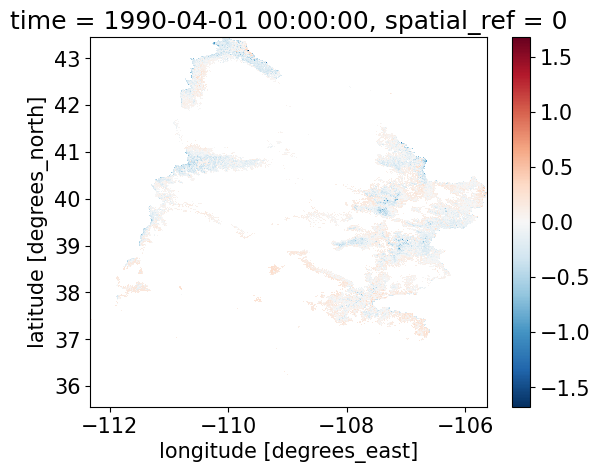

In [214]:
dif_try[0].plot()

In [53]:
swe_mapping_nearest_df = calculate_metrics(nearest_station_swe_mapping.SWE_Post, version='Nearest Station SWE', method = 'SWE Mapping')

In [76]:
metrics_df = pd.concat([quantiles_mean_all_df, mean_snv_ucrb_all_df, mean_snv_wus_coarse_df, quantiles_wus_coarse_df, snv_wus_origres_df, quantiles_wus_origres_df, snv_ucrb_origres_df,quantiles_ucrb_origres_df,nearest_snv_nc_df,nearest_quantile_nc_df,cumulative_precip_df,swe_mapping_nearest_df], ignore_index=True)

In [77]:
r_chart = alt.Chart(metrics_df).mark_boxplot(extent=1).encode(
    alt.X("Rs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

md_chart = alt.Chart(metrics_df).mark_boxplot(extent=1).encode(
    alt.X("MDs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

rmse_chart = alt.Chart(metrics_df).mark_boxplot(extent=1).encode(
    alt.X("RMSEs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

In [82]:
metrics_df_less = pd.concat([quantiles_mean_all_df, mean_snv_ucrb_all_df, nearest_snv_nc_df,nearest_quantile_nc_df,cumulative_precip_df,swe_mapping_nearest_df,mean_snv_wus_coarse_df, quantiles_wus_coarse_df], ignore_index=True)

In [60]:
#metrics_df_less.to_pickle('../../data/calculated_swe/swe_calculation_metrics_df.pkl')

In [13]:
metrics_df_less = pickle.load(open('../../data/calculated_swe/swe_calculation_metrics_df.pkl', 'rb'))

In [39]:
metrics_df_less_sm = pd.concat([metrics_df_less,snowmodel_df], ignore_index=True)

In [40]:
metrics_df_less_sm

Rs       MDs     RMSEs  year  sca_percent  \
0    0.906385 -0.005695  0.051545  1990    32.074001   
1    0.891874 -0.001007  0.061429  1991    39.685165   
2    0.824394 -0.023201  0.103181  1992    37.123160   
3    0.920979 -0.020926  0.084322  1993    59.958910   
4    0.906721  0.001160  0.048377  1994    44.536100   
..        ...       ...       ...   ...          ...   
273  0.730697 -0.015395  0.115595  2017    46.250040   
274  0.629316 -0.011377  0.160592  2018    31.495977   
275  0.790397 -0.030330  0.097363  2019    60.240114   
276  0.667929 -0.030389  0.117741  2020    50.757632   
277  0.787758 -0.020977  0.132119  2021    46.630162   

                                version    method  
0    Quantile Mean of all UCRB Stations  Quantile  
1    Quantile Mean of all UCRB Stations  Quantile  
2    Quantile Mean of all UCRB Stations  Quantile  
3    Quantile Mean of all UCRB Stations  Quantile  
4    Quantile Mean of all UCRB Stations  Quantile  
..                                  ...       ...  
273                           SnowModel   Modeled  
274                           SnowModel   Modeled  
275                           SnowModel   Modeled  
276                           SnowModel   Modeled  
277                           SnowModel   Modeled  

[278 rows x 7 columns]

In [50]:
metrics_df_less_sm[metrics_df_less_sm['method'] != 'Precip']

Rs       MDs     RMSEs  year  sca_percent  \
0    0.906385 -0.005695  0.051545  1990    32.074001   
1    0.891874 -0.001007  0.061429  1991    39.685165   
2    0.824394 -0.023201  0.103181  1992    37.123160   
3    0.920979 -0.020926  0.084322  1993    59.958910   
4    0.906721  0.001160  0.048377  1994    44.536100   
..        ...       ...       ...   ...          ...   
273  0.730697 -0.015395  0.115595  2017    46.250040   
274  0.629316 -0.011377  0.160592  2018    31.495977   
275  0.790397 -0.030330  0.097363  2019    60.240114   
276  0.667929 -0.030389  0.117741  2020    50.757632   
277  0.787758 -0.020977  0.132119  2021    46.630162   

                                version    method  
0    Quantile Mean of all UCRB Stations  Quantile  
1    Quantile Mean of all UCRB Stations  Quantile  
2    Quantile Mean of all UCRB Stations  Quantile  
3    Quantile Mean of all UCRB Stations  Quantile  
4    Quantile Mean of all UCRB Stations  Quantile  
..                                  ...       ...  
273                           SnowModel   Modeled  
274                           SnowModel   Modeled  
275                           SnowModel   Modeled  
276                           SnowModel   Modeled  
277                           SnowModel   Modeled  

[246 rows x 7 columns]

In [54]:
metrics_df_less_sm[metrics_df_less_sm['method'] != 'Precip']

Rs       MDs     RMSEs  year  sca_percent  \
0    0.906385 -0.005695  0.051545  1990    32.074001   
1    0.891874 -0.001007  0.061429  1991    39.685165   
2    0.824394 -0.023201  0.103181  1992    37.123160   
3    0.920979 -0.020926  0.084322  1993    59.958910   
4    0.906721  0.001160  0.048377  1994    44.536100   
..        ...       ...       ...   ...          ...   
273  0.730697 -0.015395  0.115595  2017    46.250040   
274  0.629316 -0.011377  0.160592  2018    31.495977   
275  0.790397 -0.030330  0.097363  2019    60.240114   
276  0.667929 -0.030389  0.117741  2020    50.757632   
277  0.787758 -0.020977  0.132119  2021    46.630162   

                                version    method  
0    Quantile Mean of all UCRB Stations  Quantile  
1    Quantile Mean of all UCRB Stations  Quantile  
2    Quantile Mean of all UCRB Stations  Quantile  
3    Quantile Mean of all UCRB Stations  Quantile  
4    Quantile Mean of all UCRB Stations  Quantile  
..                                  ...       ...  
273                           SnowModel   Modeled  
274                           SnowModel   Modeled  
275                           SnowModel   Modeled  
276                           SnowModel   Modeled  
277                           SnowModel   Modeled  

[246 rows x 7 columns]

In [55]:
metrics_sm = metrics_sm[metrics_sm['method'] != 'SWE Mapping']

In [56]:
metrics_sm

Rs       MDs     RMSEs  year  sca_percent  \
0    0.906385 -0.005695  0.051545  1990    32.074001   
1    0.891874 -0.001007  0.061429  1991    39.685165   
2    0.824394 -0.023201  0.103181  1992    37.123160   
3    0.920979 -0.020926  0.084322  1993    59.958910   
4    0.906721  0.001160  0.048377  1994    44.536100   
..        ...       ...       ...   ...          ...   
273  0.730697 -0.015395  0.115595  2017    46.250040   
274  0.629316 -0.011377  0.160592  2018    31.495977   
275  0.790397 -0.030330  0.097363  2019    60.240114   
276  0.667929 -0.030389  0.117741  2020    50.757632   
277  0.787758 -0.020977  0.132119  2021    46.630162   

                                version    method  
0    Quantile Mean of all UCRB Stations  Quantile  
1    Quantile Mean of all UCRB Stations  Quantile  
2    Quantile Mean of all UCRB Stations  Quantile  
3    Quantile Mean of all UCRB Stations  Quantile  
4    Quantile Mean of all UCRB Stations  Quantile  
..                                  ...       ...  
273                           SnowModel   Modeled  
274                           SnowModel   Modeled  
275                           SnowModel   Modeled  
276                           SnowModel   Modeled  
277                           SnowModel   Modeled  

[214 rows x 7 columns]

In [99]:
metrics_sm.loc[(metrics_sm['version'] == 'Quantile Mean of within-cluster UCRB Stations'),'version'] = 'Quantile Mean of within-cluster Stations'

In [102]:
metrics_sm.loc[(metrics_sm['version'] == 'SNV Mean of within-cluster UCRB Stations'),'version'] = 'SNV Mean of within-cluster Stations'

In [101]:
metrics_sm[metrics_sm['version'] == 'Quantile Mean of within-cluster Stations']['version']

224    Quantile Mean of within-cluster Stations
225    Quantile Mean of within-cluster Stations
226    Quantile Mean of within-cluster Stations
227    Quantile Mean of within-cluster Stations
228    Quantile Mean of within-cluster Stations
229    Quantile Mean of within-cluster Stations
230    Quantile Mean of within-cluster Stations
231    Quantile Mean of within-cluster Stations
232    Quantile Mean of within-cluster Stations
233    Quantile Mean of within-cluster Stations
234    Quantile Mean of within-cluster Stations
235    Quantile Mean of within-cluster Stations
236    Quantile Mean of within-cluster Stations
237    Quantile Mean of within-cluster Stations
238    Quantile Mean of within-cluster Stations
239    Quantile Mean of within-cluster Stations
240    Quantile Mean of within-cluster Stations
241    Quantile Mean of within-cluster Stations
242    Quantile Mean of within-cluster Stations
243    Quantile Mean of within-cluster Stations
244    Quantile Mean of within-cluster S

In [61]:
metrics_df_less[metrics_df_less['version']=='Quantile Mean of all UCRB Stations']['Rs'].median()

0.9062849054570014

In [62]:
metrics_df_less[metrics_df_less['version']=='Quantile Mean of all UCRB Stations']['MDs'].median()

-0.0031921917106956244

In [63]:
metrics_df_less[metrics_df_less['version']=='Quantile Mean of all UCRB Stations']['RMSEs'].median()

0.06109648942947388

In [64]:
metrics_df_less[metrics_df_less['version']=='Nearest Station SWE']['Rs'].median()

0.22251828354878134

In [65]:
metrics_df_less[metrics_df_less['version']=='Nearest Station SWE']['MDs'].median()

0.14967265725135803

In [66]:
metrics_df_less[metrics_df_less['version']=='Nearest Station SWE']['RMSEs'].median()

0.27245694398880005

In [67]:
metrics_df_less[metrics_df_less['version']=='PRISM Cumulative Precip']['Rs'].median()

0.4373500377277132

In [68]:
metrics_df_less[metrics_df_less['version']=='PRISM Cumulative Precip']['MDs'].median()

-0.0014498243108391762

In [69]:
metrics_df_less[metrics_df_less['version']=='PRISM Cumulative Precip']['RMSEs'].median()

0.19997569918632507

In [103]:
r_chart = alt.Chart(metrics_sm).mark_boxplot(extent=1).encode(
    alt.X("Rs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

md_chart = alt.Chart(metrics_sm).mark_boxplot(extent=1).encode(
    alt.X("MDs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

rmse_chart = alt.Chart(metrics_sm).mark_boxplot(extent=1).encode(
    alt.X("RMSEs:Q").scale(zero=False),
    alt.Y("version:N"),
    alt.Color("method")
)

concat = alt.vconcat(r_chart, md_chart, rmse_chart)
concat

alt.VConcatChart(...)

### Make a figure to show spatial distributions of SWE and errors:  
To include in the plot:  
* SWE Reanalysis ('truth' in this case)
* Quantile mapping from the within-cluster mean
* SNV mapping on the within-cluster mean
* Cumulative cold-season precipitation

In [58]:
x_lim = [-108.6, -105.3]
y_lim = [37.4, 41]
bbox_poly = Polygon([[x_lim[0], y_lim[0]], [x_lim[0], y_lim[1]],[x_lim[1], y_lim[1]],  [x_lim[1], y_lim[0]]])

In [59]:
subset_box = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bbox_poly])

### Get elevation data for plotting:

In [139]:
ucrb_dem = rxr.open_rasterio('../../data/misc/ucrb_dem_32613_150m.tif', masked=True).squeeze()

In [140]:
ucrb_dem

<xarray.DataArray (y: 6315, x: 4250)> Size: 107MB
[26838750 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 34kB -1.486e+05 -1.485e+05 ... 4.463e+05 4.464e+05
  * y            (y) float64 51kB 4.823e+06 4.823e+06 ... 3.939e+06 3.939e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:          Area
    BandDefinitionKeyword:  *
    DataType:               *
    DESCRIPTION:            *
    LAYER_TYPE:             *
    RepresentationType:     *
    scale_factor:           1.0
    add_offset:             0.0

In [67]:
snowmodel_dem = xr.open_dataset('../../data/snowmodel/sm_swed_04_01_2000_2021.nc', decode_coords="all")

In [68]:
snowmodel_dem = snowmodel_dem.transpose('Year', 'y', 'x')

In [70]:
snowmodel_dem.hgt

<xarray.DataArray 'hgt' (y: 6887, x: 5871)> Size: 162MB
[40433577 values with dtype=float32]
Coordinates:
  * x        (x) float64 47kB -112.4 -112.4 -112.4 ... -105.5 -105.5 -105.5
  * y        (y) float64 55kB 43.55 43.55 43.55 43.55 ... 35.46 35.46 35.46

In [71]:
snowmodel_dem = snowmodel_dem.hgt

In [74]:
snowmodel_dem = snowmodel_dem.rio.write_crs('epsg:4326')

In [75]:
snowmodel_dem = snowmodel_dem.rio.clip(ucrb.geometry)

In [77]:
snowmodel_dem = snowmodel_dem.rio.reproject_match(swe.SWE_Post[0])

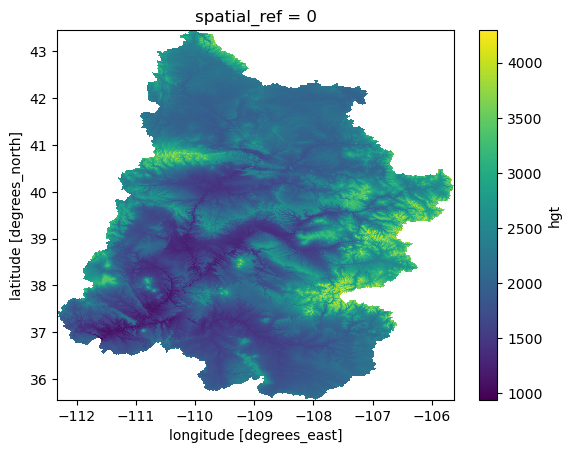

In [78]:
snowmodel_dem.plot()

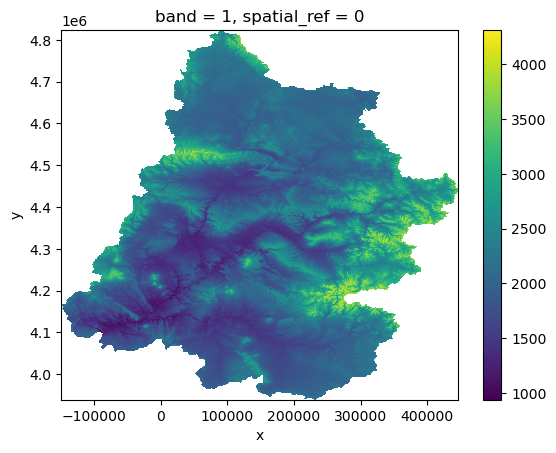

In [141]:
ucrb_dem.plot()

In [143]:
ucrb_dem = ucrb_dem.rio.reproject('epsg:32612')

In [108]:
swe.SWE_Post[0].rio.bounds()

(-112.32836350084696,
 35.56002982018699,
 -105.62637893079366,
 43.45337121130715)

In [79]:
ucrb_x_lim = [swe.SWE_Post[0].rio.bounds()[0], swe.SWE_Post[0].rio.bounds()[2]]
ucrb_y_lim = [swe.SWE_Post[0].rio.bounds()[1], swe.SWE_Post[0].rio.bounds()[3]]
ucrb_bbox_poly = Polygon([[ucrb_x_lim[0], ucrb_y_lim[0]], [ucrb_x_lim[0], ucrb_y_lim[1]],[ucrb_x_lim[1], ucrb_y_lim[1]],  [ucrb_x_lim[1], ucrb_y_lim[0]]])

In [80]:
ucrb_bbox_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[ucrb_bbox_poly])

In [81]:
import pystac_client
import planetary_computer
import odc.stac
odc.stac.configure_rio(cloud_defaults=True)

ModuleNotFoundError: No module named 'odc'

In [82]:
resolution = int(30)

In [117]:
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",modifier=planetary_computer.sign_inplace)
search = catalog.search(collections=[f"cop-dem-glo-{resolution}"],bbox=ucrb_bbox_gdf.total_bounds)
cop_dem_da = odc.stac.load(search.items(),bbox=ucrb_bbox_gdf.total_bounds,chunks={})['data'].squeeze()
cop_dem_da = cop_dem_da.rio.write_nodata(np.nan,encoded=True)

NameError: name 'odc' is not defined

### Calculate all the differences from the SWE Reanalysis product:

In [115]:
# Mean of all stations in the UCRB
calculated_swe_mean_snv_ucrb_all_dif = calculated_swe_mean_snv_ucrb_all.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)
calculated_swe_quantiles_mean_all_dif = calculated_swe_quantiles_mean_all.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)

In [116]:
# Mean of within-station clusters, by different cluster definitions
calculated_swe_mean_snv_wus_coarse_dif = calculated_swe_mean_snv_wus_coarse.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) 
calculated_swe_quantiles_wus_coarse_q8_dif = calculated_swe_quantiles_wus_coarse_q8.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) 
# calculated_swe_mean_snv_wus_origres_dif = calculated_swe_mean_snv_wus_origres.SWE_Post - swe.SWE_Post
# calculated_swe_quantiles_wus_origres_q8_dif = calculated_swe_quantiles_wus_origres_q8.SWE_Post - swe.SWE_Post
# calculated_swe_mean_snv_ucrb_origres_dif = calculated_swe_mean_snv_ucrb_origres.SWE_Post - swe.SWE_Post
# calculated_swe_quantiles_ucrb_origres_q8_dif = calculated_swe_quantiles_ucrb_origres_q8.SWE_Post - swe.SWE_Post

In [117]:
# Nearest station
calculated_swe_nearest_snv_nc_dif = calculated_swe_nearest_snv_nc.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)
calculated_swe_nearest_station_quantile_q8_dif = calculated_swe_nearest_station_quantile_q8.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post.where(swe.SWE_Post.mean(dim='Year')>0)

In [87]:
# Cumulative precipitation
swe_year = swe.rename(Year="time")
swe_year['time'] = xr.cftime_range(start="1990", periods=32, freq="YS-APR", calendar="noleap")
calculated_swe_precip_dif = calculated_swe_precip.__xarray_dataarray_variable__ - swe_year.SWE_Post

# SWE mapping from nearest station
nearest_station_swe_mapping_dif = nearest_station_swe_mapping.SWE_Post - swe.SWE_Post

In [118]:
# SnowModel
snowmodel_dif = snowmodel.swed.where(swe.SWE_Post.mean(dim='Year')>0) - swe.SWE_Post[10:].where(swe.SWE_Post.mean(dim='Year')>0)

### Plot the spatial differences in a subset region of the UCRB:

In [171]:
ucrb_neg = gpd.read_file('../../data/misc/neg_ucrb.geojson')

In [173]:
ucrb_neg = gpd.overlay(ucrb_neg, ucrb, how='difference')

In [182]:
from matplotlib_scalebar.scalebar import ScaleBar

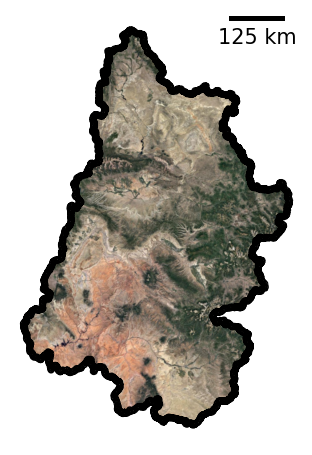

In [184]:
fig, ax = plt.subplots()
ucrb.to_crs('epsg:32613').plot(ax=ax, facecolor='none', edgecolor='k', linewidth=5, zorder=3)
ctx.add_basemap(ax=ax, crs='epsg:32613', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False, zorder=1)
ucrb_neg.to_crs('epsg:32613').plot(ax=ax, facecolor='white', zorder=2)
ax.set_title('')
# ax.set_xlim(-112.4,x_lim[1]-0.2)
# ax.set_ylim(35.5, 43.5)
ax.add_artist(ScaleBar(1))
ax.set_axis_off()
plt.tight_layout()
plt.savefig('../../figures/ucrb_imagery.jpeg', dpi=300)

In [147]:
ucrb_dem_match = ucrb_dem.rio.reproject_match(swe.SWE_Post[0])

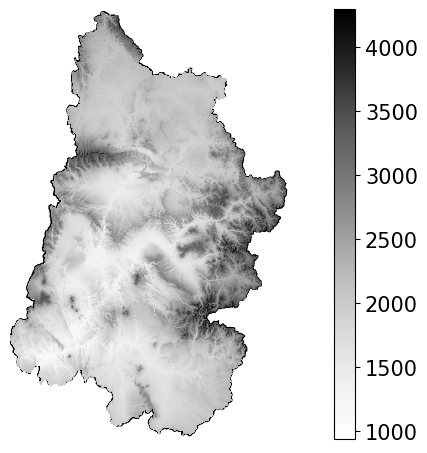

In [165]:
fig, ax = plt.subplots()

ucrb.plot(ax=ax, facecolor='none', edgecolor='k')
ucrb_dem_match.plot(ax=ax,cmap='Greys')
#subset_box.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3)
ax.set_title('')
ax.set_xlim(-112.3,x_lim[1]+0.1)
ax.set_ylim(35.5, 43.5)
ax.set_axis_off()
plt.tight_layout()
plt.savefig('../../figures/ucrb_elevation.jpeg', dpi=300)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/2808365427.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


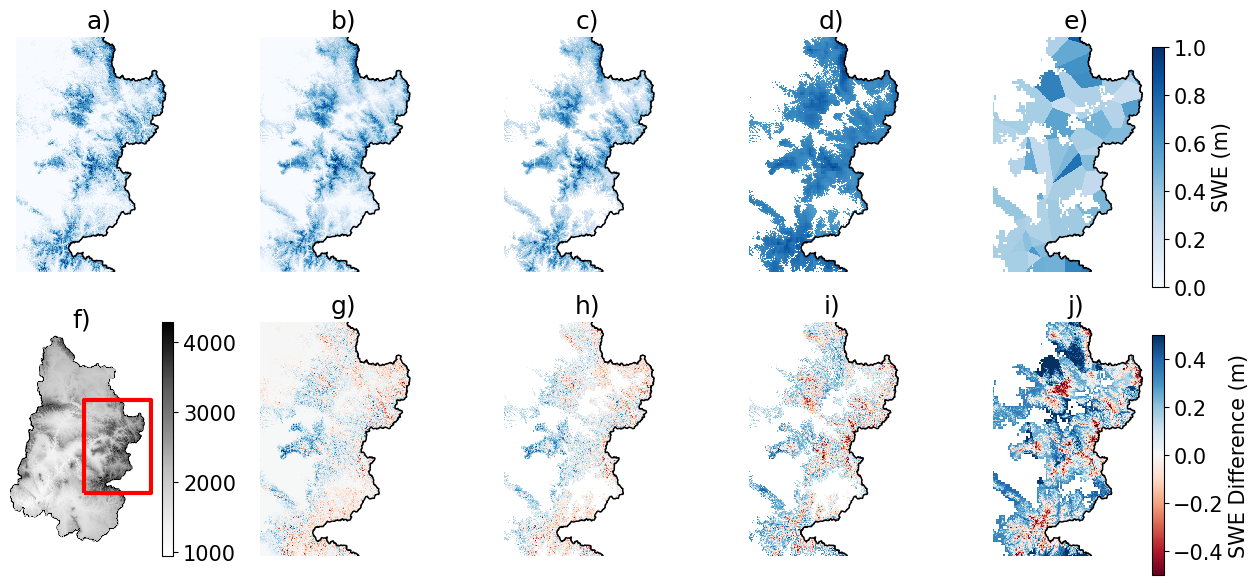

In [186]:
plt.rcParams.update({'font.size': 15})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=5, attribution=False, zorder=)
#ctx.add_basemap(ax=ax, crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
ucrb_dem_match.plot(ax=ax[1,0],cmap='Greys')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('f)')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('a)')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('b)')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('c)')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[30].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('d)')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[30].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('g)')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[30].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('h)')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[30].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('i)')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[30].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('e)')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[30].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('j)')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.97, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.97, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

# cbar_ax3 = fig.add_axes([0.2, 0.5, 0.01, 0.4])
# plt.colorbar(cb5, cax=cbar_ax2, label='Elevation (m)', orientation='vertical')

plt.tight_layout()
plt.savefig('../../figures/calculated_swe_comparison_2020_labels.jpeg',dpi=300)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_756/2211110914.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


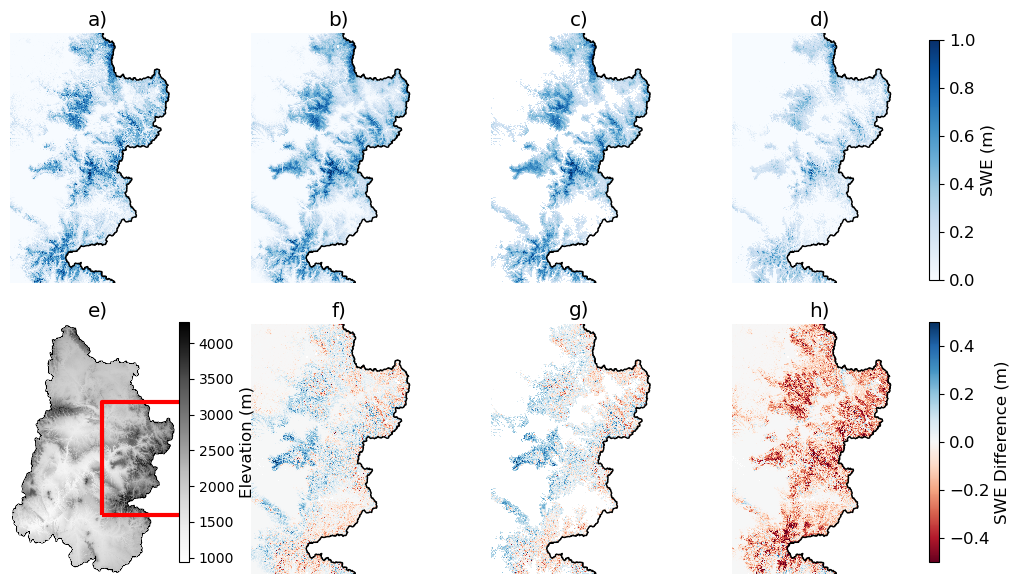

In [119]:
plt.rcParams.update({'font.size': 12})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,4, figsize=(10,6))

#cb0 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=5, attribution=False, zorder=)
#ctx.add_basemap(ax=ax, crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
cb0 = snowmodel_dem.plot(ax=ax[1,0],cmap='Greys', label='Elevation (m)', add_colorbar=False)
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('e)')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('a)')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('b)')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('c)')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = snowmodel.swed[20].plot(cmap='Blues', ax=ax[0,3], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('d)')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[30].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('f)')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[30].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('g)')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = snowmodel_dif[20].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('h)')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

# cb8 = nearest_station_swe_mapping.SWE_Post[30].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
# ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
# ax[0,4].set_title('e)')
# ax[0,4].set_axis_off()
# ax[0,4].set_xlim(x_lim)
# ax[0,4].set_ylim(y_lim)

# cb8 = nearest_station_swe_mapping_dif[30].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
# ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
# ax[1,4].set_title('i)')
# ax[1,4].set_axis_off()
# ax[1,4].set_xlim(x_lim)
# ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.97, 0.52, 0.01, 0.4])
plt_cbar = plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')
plt_cbar.ax.tick_params(labelsize=12)

cbar_ax2 = fig.add_axes([0.97, 0.05, 0.01, 0.4])
plt_cbar2 = plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')
plt_cbar2.ax.tick_params(labelsize=12)

cbar_ax0 = fig.add_axes([0.22, 0.05, 0.01, 0.4])
plt_cbar0 = plt.colorbar(cb0, cax=cbar_ax0, label='Elevation (m)', orientation='vertical')
plt_cbar0.ax.tick_params(labelsize=10)

# cbar_ax3 = fig.add_axes([0.2, 0.5, 0.01, 0.4])
# plt.colorbar(cb5, cax=cbar_ax2, label='Elevation (m)', orientation='vertical')

plt.tight_layout()
plt.savefig('../../figures/calculated_swe_comparison_2020_sm.jpeg',dpi=300)

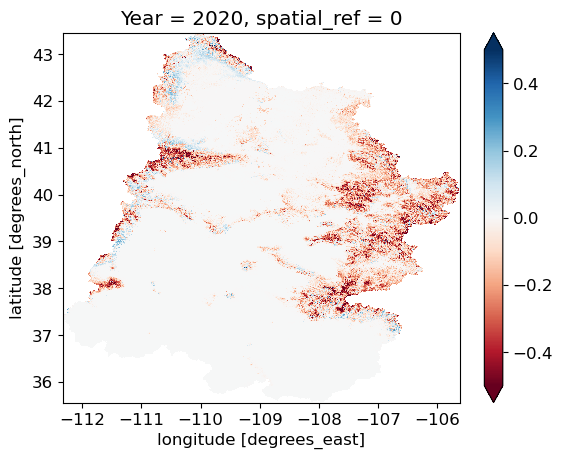

In [114]:
snowmodel_dif[20].plot(cmap='RdBu', vmin=-0.5, vmax=0.5)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/187348568.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


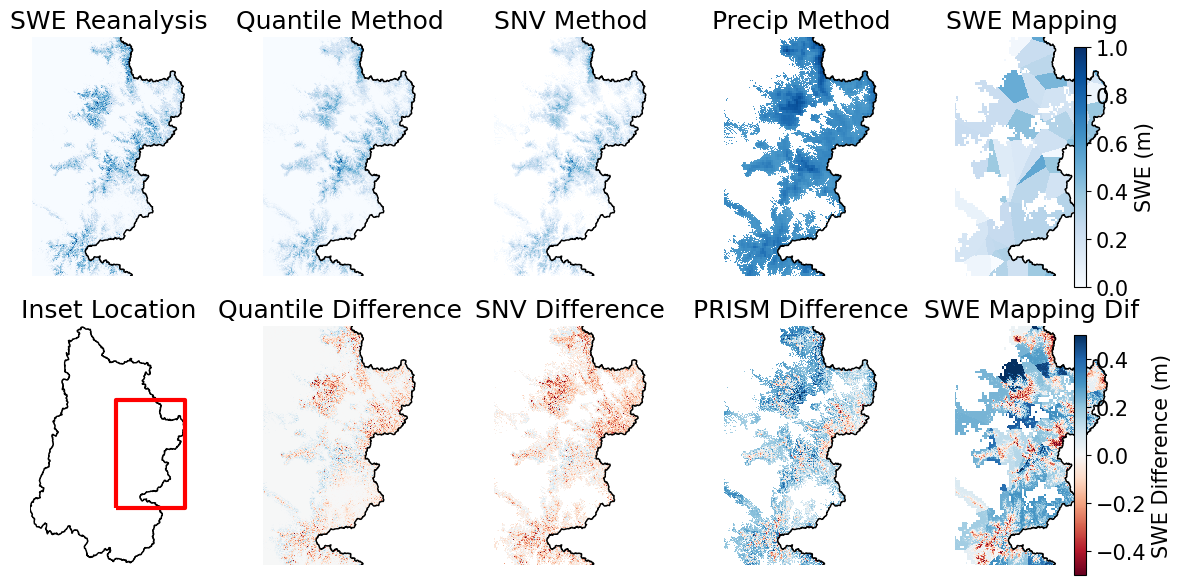

In [94]:
plt.rcParams.update({'font.size': 15})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[25].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[25].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[25].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[25].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[25].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[25].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[25].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[25].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[25].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[25].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/579926206.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


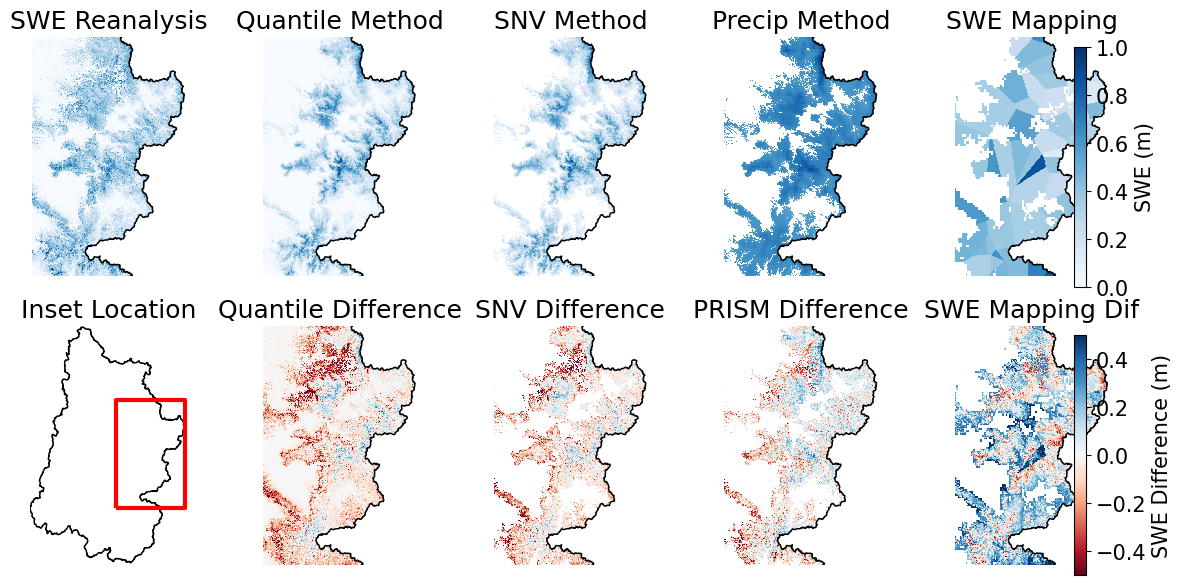

In [95]:
plt.rcParams.update({'font.size': 15})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[20].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[20].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[20].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[20].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[20].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[20].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[20].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[20].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[20].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[20].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/4131655805.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


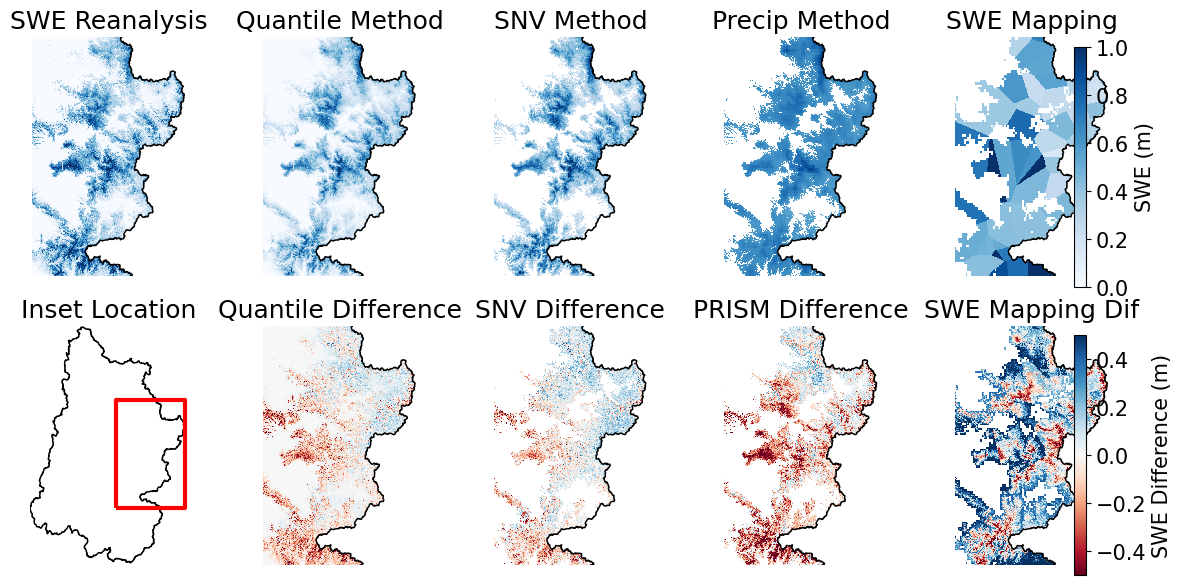

In [96]:
plt.rcParams.update({'font.size': 15})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[15].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[15].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[15].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[15].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[15].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[15].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[15].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[15].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[15].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[15].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/407633630.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


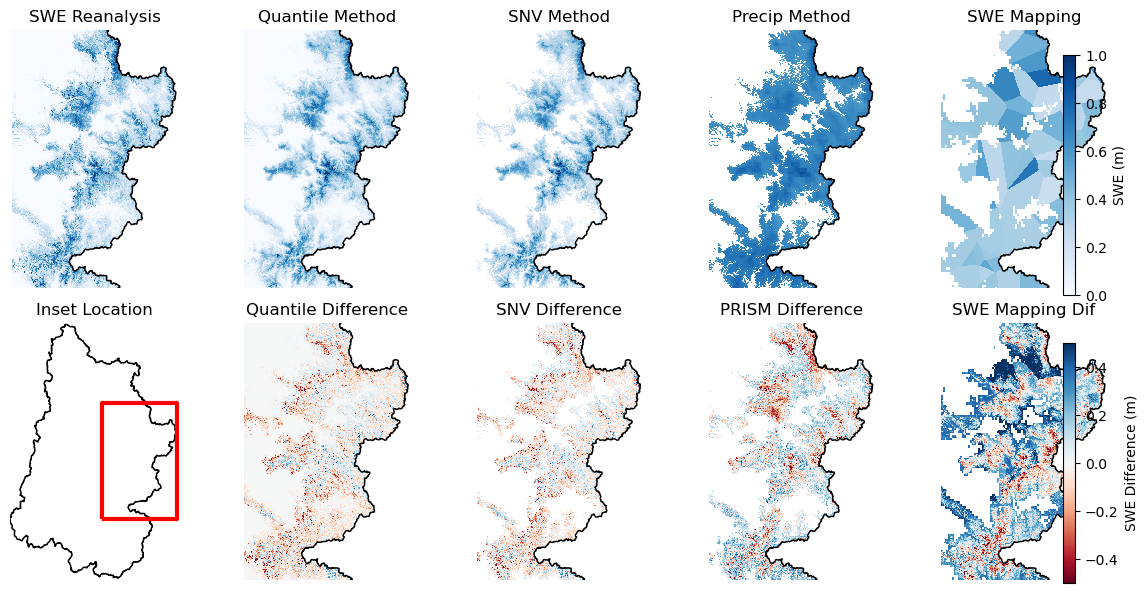

In [97]:
plt.rcParams.update({'font.size': 10})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[10].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[10].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[10].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[10].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[10].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[10].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[10].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[10].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[10].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[10].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/2548214421.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


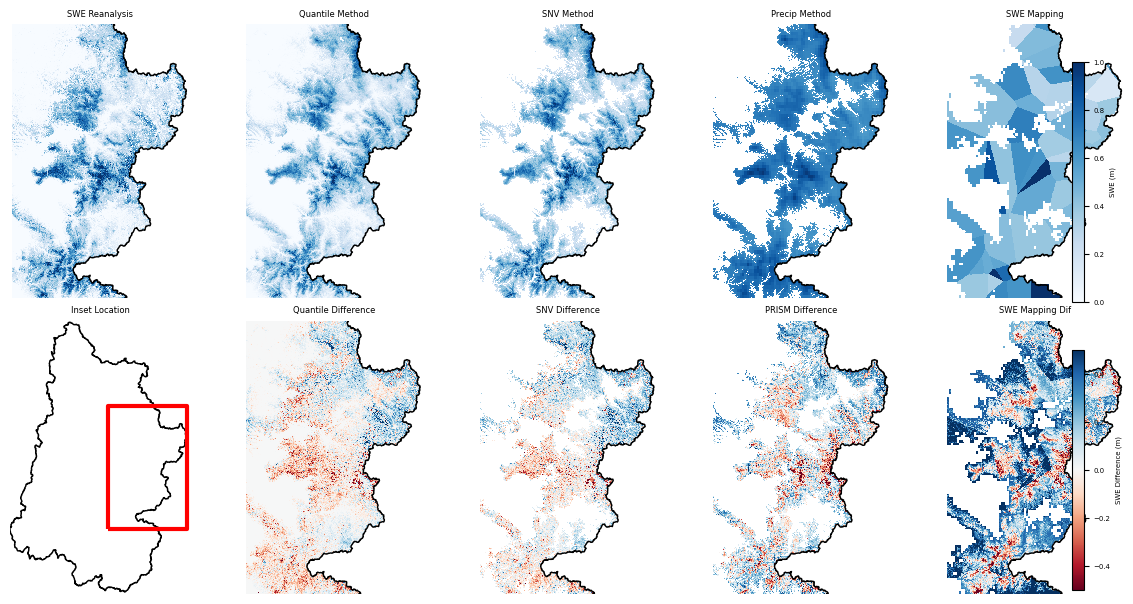

In [98]:
plt.rcParams.update({'font.size': 5})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[5].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[5].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[5].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[5].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[5].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[5].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[5].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[5].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[5].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[5].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_6428/2182642103.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


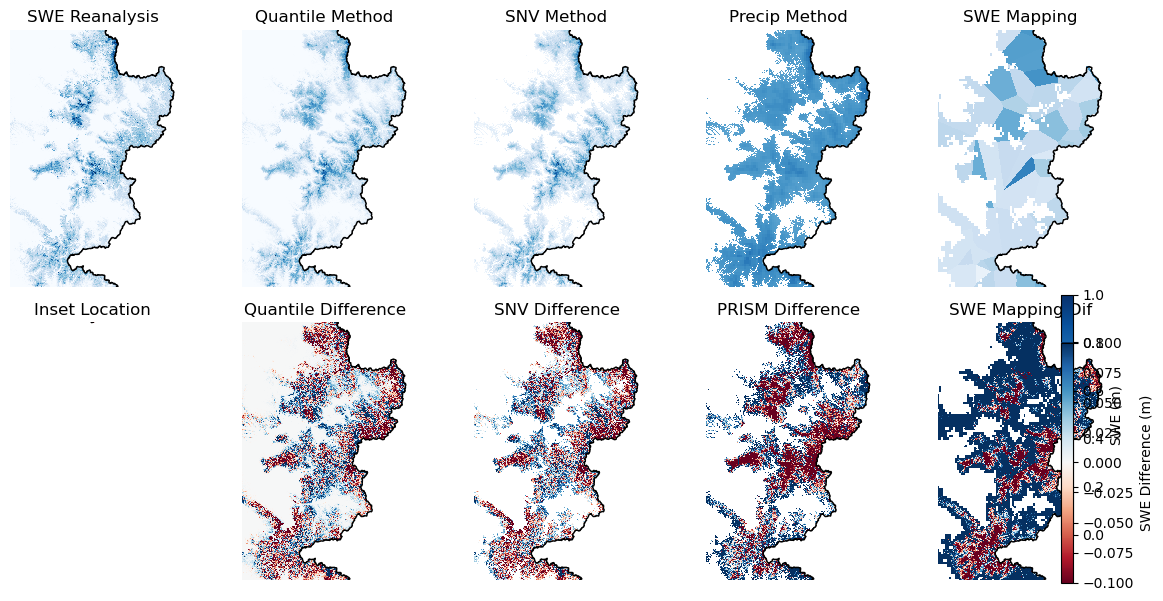

In [103]:
plt.rcParams.update({'font.size': 10})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,5, figsize=(12,6))

#cb0 = swe.SWE_Post[10].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], crs='epsg:4326', source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom=8, attribution=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(310.10, 43.10)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[0].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[0].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[0].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[0].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb10 = calculated_swe_quantiles_mean_all_dif[0].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.10,vmax=0.10, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[0].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.10,vmax=0.10, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[0].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.10,vmax=0.10, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping.SWE_Post[0].plot(cmap='Blues', ax=ax[0,4], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,4], facecolor='none', edgecolor='k')
ax[0,4].set_title('SWE Mapping')
ax[0,4].set_axis_off()
ax[0,4].set_xlim(x_lim)
ax[0,4].set_ylim(y_lim)

cb8 = nearest_station_swe_mapping_dif[0].plot(cmap='RdBu', ax=ax[1,4], vmin=-0.10,vmax=0.10, add_colorbar=False)
ucrb.plot(ax=ax[1,4], facecolor='none', edgecolor='k')
ax[1,4].set_title('SWE Mapping Dif')
ax[1,4].set_axis_off()
ax[1,4].set_xlim(x_lim)
ax[1,4].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.10, 0.01, 0.4])
plt.colorbar(cb1, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb10, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()

In [172]:
x_lim2 = [-106.05, -106]
y_lim2 = [39.96, 40]
bbox_poly2 = Polygon([[x_lim2[0], y_lim2[0]], [x_lim2[0], y_lim2[1]],[x_lim2[1], y_lim2[1]],  [x_lim2[1], y_lim2[0]]])

In [170]:
subset_box2 = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bbox_poly2])

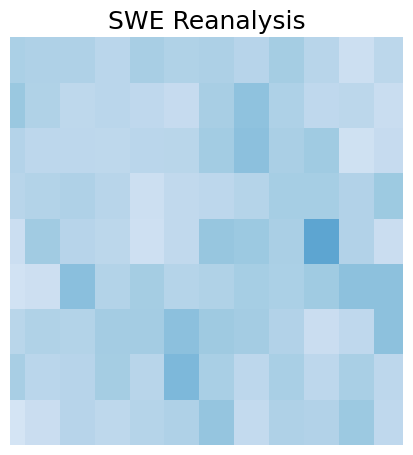

In [173]:

fig, ax = plt.subplots()
cb1 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax, vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_title('SWE Reanalysis')
ax.set_axis_off()
ax.set_xlim(x_lim2)
ax.set_ylim(y_lim2)
plt.tight_layout()
plt.savefig('../../figures/gridded_swe_conceptual.jpeg', dpi=300)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_2476/3530847604.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


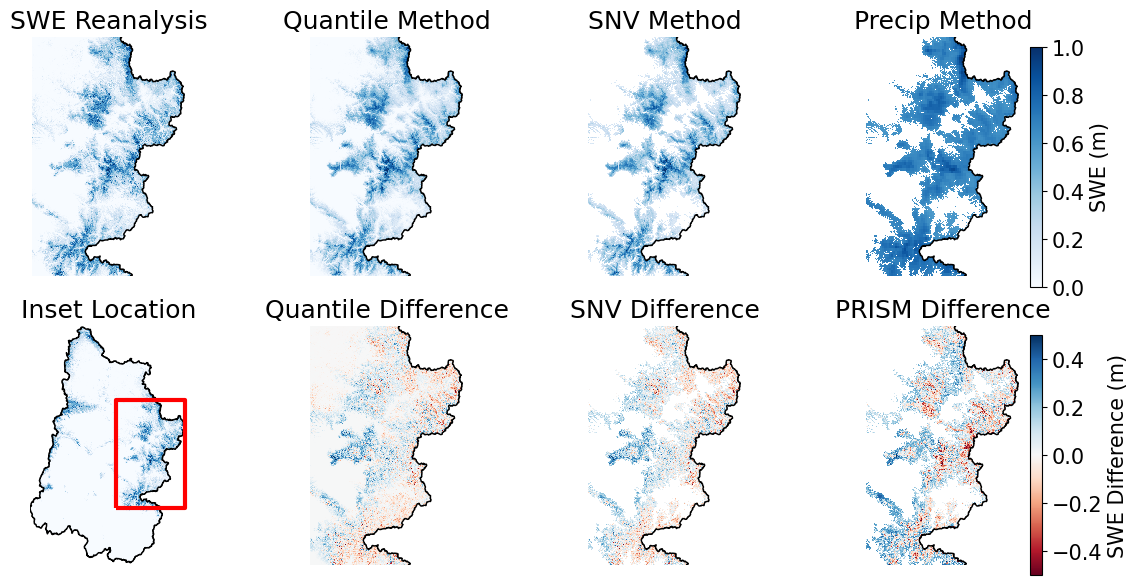

In [123]:
plt.rcParams.update({'font.size': 15})

#basemap = ctx.providers.Esri.WorldImagery

fig, ax = plt.subplots(2,4, figsize=(12,6))

cb0 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
#ctx.add_basemap(ax=ax[1,0], attribution=False, crs='epsg:4326', source=basemap, zoom=9)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = swe.SWE_Post[30].plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_ucrb_all.SWE_Post[30].plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_precip.__xarray_dataarray_variable__[30].plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantiles_mean_all_dif[30].plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_mean_snv_ucrb_all_dif[30].plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_precip_dif[30].plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)


# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb0, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()
plt.savefig('../../figures/calculated_swe_comparison_2020_.jpeg',dpi=300)

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_788/761168149.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


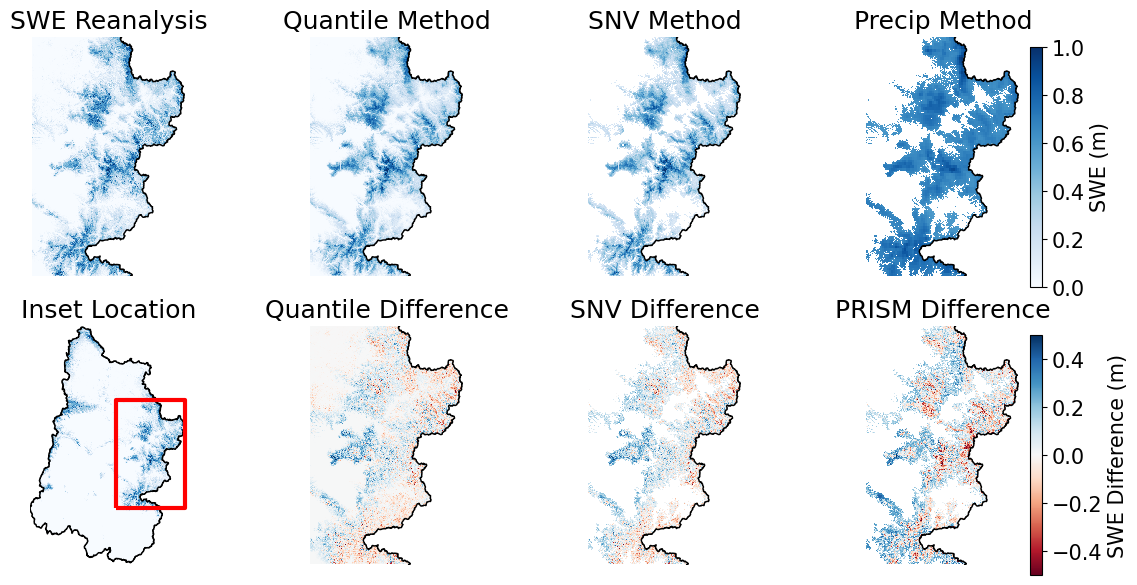

In [205]:
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(2,4, figsize=(12,6))

cb0 = swe_reanalysis.SWE_Post[30].plot(cmap='Blues', ax=ax[1,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[1,0], facecolor='none', edgecolor='k')
#subset_box.plot(ax=ax[1,0], facecolor='none', edgecolor='red', linewidth=3)
ax[1,0].set_title('Inset Location')
ax[1,0].set_xlim(-112.3,x_lim[1]+0.1)
ax[1,0].set_ylim(35.5, 43.5)
ax[1,0].set_axis_off()
# fig.colorbar(cb, ax=ax[0,0])
# fig.delaxes(fig.ax[0,0])

cb1 = calculated_swe_mean_snv_ucrb_all_dif.plot(cmap='Blues', ax=ax[0,0], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
ax[0,0].set_title('SWE Reanalysis')
ax[0,0].set_axis_off()
ax[0,0].set_xlim(x_lim)
ax[0,0].set_ylim(y_lim)

cb2 = calculated_swe_quantiles_mean_all_dif .plot(cmap='Blues', ax=ax[0,1], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,1], facecolor='none', edgecolor='k')
ax[0,1].set_title('Quantile Method')
ax[0,1].set_axis_off()
ax[0,1].set_xlim(x_lim)
ax[0,1].set_ylim(y_lim)

cb3 = calculated_swe_mean_snv_wus_coarse.plot(cmap='Blues', ax=ax[0,2], vmin=0,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,2], facecolor='none', edgecolor='k')
ax[0,2].set_title('SNV Method')
ax[0,2].set_axis_off()
ax[0,2].set_xlim(x_lim)
ax[0,2].set_ylim(y_lim)

cb4 = calculated_swe_prism_cut.plot(cmap='Blues', ax=ax[0,3], vmin=-1,vmax=1, add_colorbar=False)
ucrb.plot(ax=ax[0,3], facecolor='none', edgecolor='k')
ax[0,3].set_title('Precip Method')
ax[0,3].set_axis_off()
ax[0,3].set_xlim(x_lim)
ax[0,3].set_ylim(y_lim)

cb5 = calculated_swe_quantile_meanall_dif_cut.plot(cmap='RdBu', ax=ax[1,1], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,1], facecolor='none', edgecolor='k')
ax[1,1].set_title('Quantile Difference')
ax[1,1].set_axis_off()
ax[1,1].set_xlim(x_lim)
ax[1,1].set_ylim(y_lim)

cb6 = calculated_swe_snv_dif_cut.plot(cmap='RdBu', ax=ax[1,2], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,2], facecolor='none', edgecolor='k')
ax[1,2].set_title('SNV Difference')
ax[1,2].set_axis_off()
ax[1,2].set_xlim(x_lim)
ax[1,2].set_ylim(y_lim)

cb7 = calculated_swe_prism_dif_cut.plot(cmap='RdBu', ax=ax[1,3], vmin=-0.5,vmax=0.5, add_colorbar=False)
ucrb.plot(ax=ax[1,3], facecolor='none', edgecolor='k')
ax[1,3].set_title('PRISM Difference')
ax[1,3].set_axis_off()
ax[1,3].set_xlim(x_lim)
ax[1,3].set_ylim(y_lim)

# [left, bottom, width, height]
cbar_ax = fig.add_axes([0.92, 0.5, 0.01, 0.4])
plt.colorbar(cb0, cax=cbar_ax, label='SWE (m)', orientation='vertical')

cbar_ax2 = fig.add_axes([0.92, 0.02, 0.01, 0.4])
plt.colorbar(cb5, cax=cbar_ax2, label='SWE Difference (m)', orientation='vertical')

plt.tight_layout()
#plt.savefig('../figures/calculated_swe_comparison_2020.jpeg',dpi=300)

### Investigate whether higher resolution clustering reduces the impact of elevation of the spatial distribution of errors:

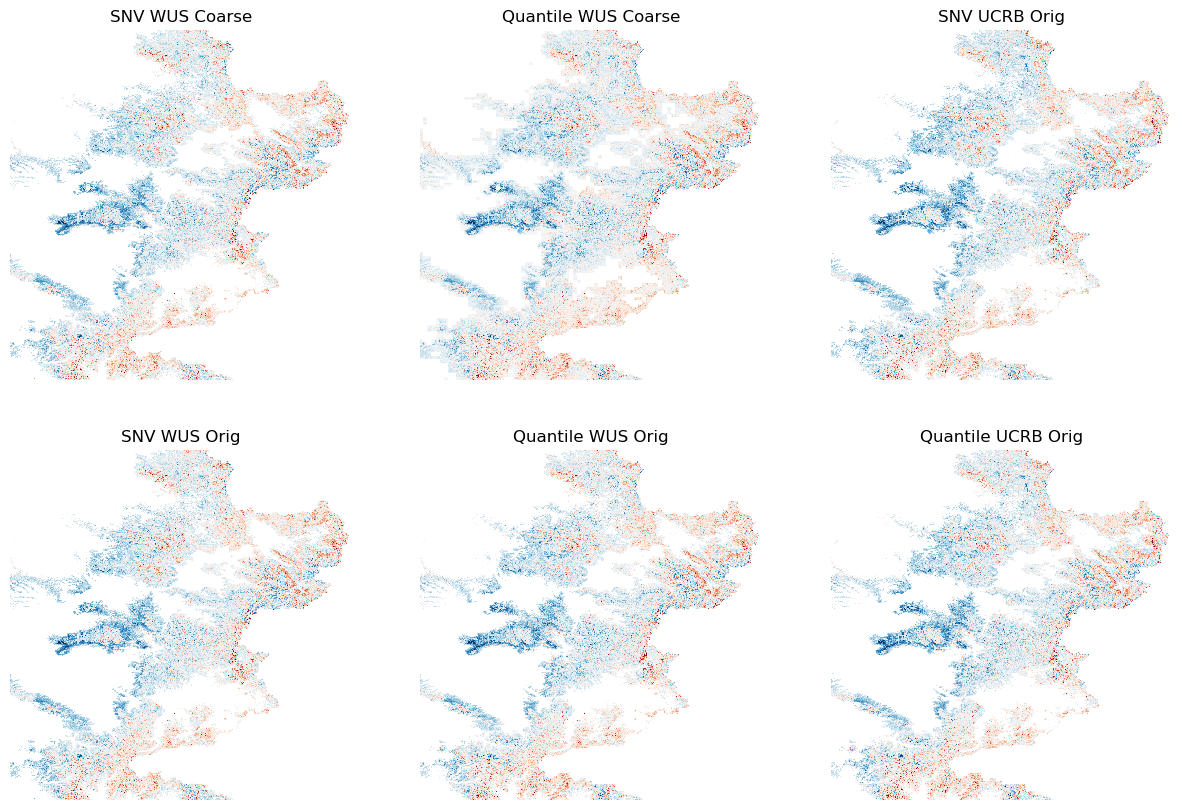

In [89]:
fig, ax = plt.subplots(2,3, figsize=(15,10))

calculated_swe_mean_snv_wus_coarse_dif[30].plot(ax=ax[0,0],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[0,0].set_title('SNV WUS Coarse')

calculated_swe_quantiles_wus_coarse_q8_dif[30].plot(ax=ax[0,1],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[0,1].set_title('Quantile WUS Coarse')

calculated_swe_mean_snv_wus_origres_dif[30].plot(ax=ax[1,0],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[1,0].set_title('SNV WUS Orig')

calculated_swe_quantiles_wus_origres_q8_dif[30].plot(ax=ax[1,1],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[1,1].set_title('Quantile WUS Orig')

calculated_swe_mean_snv_ucrb_origres_dif[30].plot(ax=ax[0,2],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[0,2].set_title('SNV UCRB Orig')

calculated_swe_quantiles_ucrb_origres_q8_dif[30].plot(ax=ax[1,2],vmin=-0.5,vmax=0.5, cmap='RdBu', add_colorbar=False)
ax[1,2].set_title('Quantile UCRB Orig')

for axis in ax.reshape(-1):
    axis.set_xlim(x_lim)
    axis.set_ylim(y_lim)
    axis.set_axis_off()

#### I could use a DEM in the Inset Location perhaps